In [ ]:
import os
!pip install --upgrade transformers --quiet
!pip install tensorflow==2.18 --quiet


In [ ]:

!pip install datasets evaluate accelerate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install optuna --quiet

In [ ]:
#importamos las librerias necesarias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from datasets import Dataset
from transformers import Trainer
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



1. Se carga la base de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#obtenemos los datos
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
#df.head(7)

df=df.dropna()

In [ ]:
print(df.shape)

(18285, 5)


In [ ]:
#Creamos el dataset

#df = load_dataset("csv", data_files={"train": "/content/train.csv", "test": ["/content/test.csv", "/content/submit.csv"] })
dataset_train = Dataset.from_pandas(df)


In [ ]:
ds = dataset_train.train_test_split(test_size=0.2, shuffle=True, seed=42)
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', '__index_level_0__'],
        num_rows: 14628
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', '__index_level_0__'],
        num_rows: 3657
    })
})

2. procesamiento de los textos

In [ ]:
# Initialize the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

2.1 Se realiza el proceso de tokenización

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["title"], padding="max_length", truncation=True, max_length=128)

# Apply the tokenizer to the dataset
tokenized_datasets = ds.map(tokenize_function, batched=True)

# Inspect tokenized samples
print(tokenized_datasets["train"][0])

Map:   0%|          | 0/14628 [00:00<?, ? examples/s]

Map:   0%|          | 0/3657 [00:00<?, ? examples/s]

{'id': 16395, 'title': 'I sense a giant earthquake will happen today', 'author': 'Anonymous Coward (UID 73269813)', 'text': "Report Copyright Violation I sense a giant earthquake will happen today I don't know where. Hopefully it's just in my pants, but seriously though, something makes me feel 7.0+ is coming within a day or so. Page 1", 'label': 1, '__index_level_0__': 16395, 'input_ids': [101, 1045, 3168, 1037, 5016, 8372, 2097, 4148, 2651, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

3. Se ejecuta el entrenamiento a partir de la transferencia del aprendizaje

3.1 se descarga el modelo

In [ ]:
from transformers import AutoModelForSequenceClassification

# Initialize a BERT model for binary classification
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

print(model.config)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
import torch.nn as nn

class CustomBERTModel(nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(output[1])  # Applying dropout
        logits = self.fc(pooled_output)  # Adding a fully connected layer
        return logits

# Initialize the custom model
custom_model = CustomBERTModel("bert-base-uncased", num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments


# Se definen los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",           # Directory for saving model checkpoints
    eval_strategy="epoch",     # Evaluate at the end of each epoch
    learning_rate=1e-3,              # Start with a small learning rate
    per_device_train_batch_size=16,  # Batch size per GPU
    per_device_eval_batch_size=16,
    num_train_epochs=3,              # Number of epochs
    weight_decay=0.01,               # Regularization
    save_total_limit=2,              # Limit checkpoints to save space
    load_best_model_at_end=True,     # Automatically load the best checkpoint
    logging_dir="./logs",            # Directory for logs
    logging_steps=100,               # Log every 100 steps
    fp16=True,                       # Enable mixed precision for faster training
    save_strategy="epoch"            # Save checkpoints at the end of each epoch to match evaluation strategy
)

print(training_args)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False

In [ ]:
# Freeze all layers except the classifier
for param in model.bert.parameters():
    param.requires_grad = False

# Keep only the classification head trainable
for param in model.classifier.parameters():
    param.requires_grad = True

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Trainable parameters: 1538


In [ ]:
#from transformers import Trainer
from evaluate import load

# Load a metric (Accuracy in this case)
metric = load("accuracy")

# Define a custom compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:

from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tata-patricia (tata-patricia-javeriana-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.394900,0.320028,0.869565
2,0.370600,0.299610,0.868471
3,0.361000,0.295594,0.866010


TrainOutput(global_step=2745, training_loss=0.40166414048936633, metrics={'train_runtime': 139.6102, 'train_samples_per_second': 314.332, 'train_steps_per_second': 19.662, 'total_flos': 2886591388354560.0, 'train_loss': 0.40166414048936633, 'epoch': 3.0})

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print(results)

{'eval_loss': 0.2955942153930664, 'eval_accuracy': 0.8660103910308996, 'eval_runtime': 4.0089, 'eval_samples_per_second': 912.221, 'eval_steps_per_second': 57.123, 'epoch': 3.0}


              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2088
           1       0.84      0.84      0.84      1569

    accuracy                           0.87      3657
   macro avg       0.86      0.86      0.86      3657
weighted avg       0.87      0.87      0.87      3657



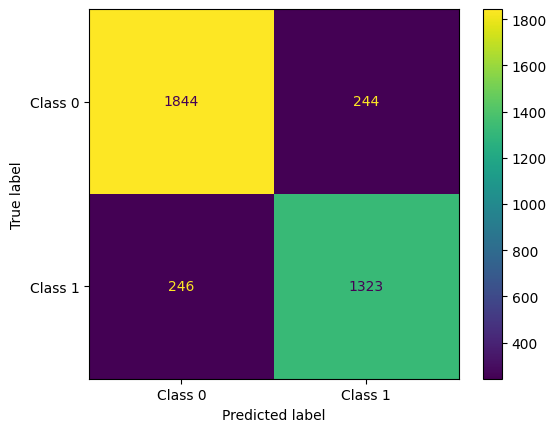

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Generar predicciones
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = predictions.predictions.argmax(axis=-1)

# Generar reporte
print(classification_report(tokenized_datasets["test"]["label"], predicted_labels))

# Matriz de confusión
cm = confusion_matrix(tokenized_datasets["test"]["label"], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot()

In [ ]:
print(predictions)
print("predicted_labels")
print(predicted_labels)
print(tokenized_datasets["test"]["label"])

PredictionOutput(predictions=array([[-0.00698853, -0.79785156],
       [ 0.44482422, -1.3193359 ],
       [-0.5024414 , -0.42236328],
       ...,
       [ 0.9140625 , -1.8330078 ],
       [-1.3691406 ,  0.54833984],
       [-0.59521484, -0.27392578]], dtype=float32), label_ids=array([1, 0, 1, ..., 0, 1, 0]), metrics={'test_loss': 0.2955942153930664, 'test_accuracy': 0.8660103910308996, 'test_runtime': 4.2599, 'test_samples_per_second': 858.464, 'test_steps_per_second': 53.757})
predicted_labels
[0 0 1 ... 0 1 1]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0

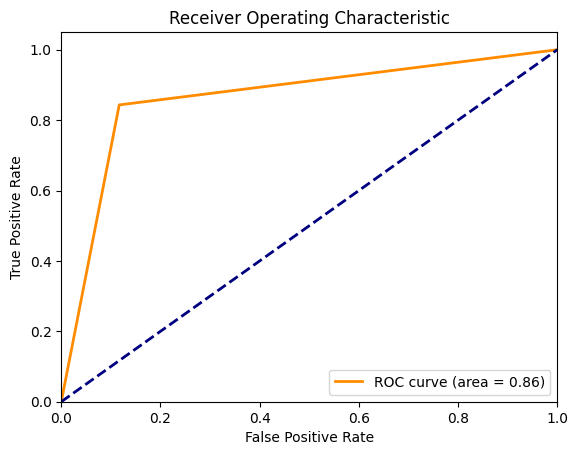

In [ ]:

#Curva Roc
fpr, tpr, thresholds = roc_curve(tokenized_datasets["test"]["label"], predicted_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc = roc_auc_score(tokenized_datasets["test"]["label"], predicted_labels)
accuracy = accuracy_score(tokenized_datasets["test"]["label"], predicted_labels)
precision = precision_score(tokenized_datasets["test"]["label"], predicted_labels)
recall = recall_score(tokenized_datasets["test"]["label"], predicted_labels)
f1 = f1_score(tokenized_datasets["test"]["label"], predicted_labels)

In [ ]:
# Calculo de metricas
print(f"AUC - ROC Score: {roc_auc:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

AUC - ROC Score: 0.86
Accuracy: 0.87
Precision: 0.84
Recall: 0.84
F1 Score: 0.84



#Hyperparameter Tuning
Síntonización de hiperparámetros usando Optuna

In [ ]:
import optuna

def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_train_epochs = trial.suggest_int("num_train_epochs", 1, 15)

    training_args = TrainingArguments(
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        output_dir="./results",
    )

    trainer_b = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        compute_metrics=compute_metrics
    )
    trainer_b.train()
    result = trainer_b.evaluate()

    return result["eval_accuracy"]

study = optuna.create_study(direction="maximize", study_name="my_study")

study.optimize(objective, n_trials=10)

print(study.best_params)
print(f'best trial: {study.best_trial.number}, best param: {study.best_params}, best_value: {study.best_value}')

[I 2025-04-24 23:52:35,391] A new study created in memory with name: no-name-fea931cd-99bf-46bf-985b-d67f7afec420


Step,Training Loss
500,0.342500
1000,0.343200
1500,0.338500
2000,0.339400
2500,0.341600
3000,0.339600
3500,0.341100
4000,0.343900
4500,0.336300
5000,0.340400


[I 2025-04-24 23:56:54,474] Trial 0 finished with value: 0.8783155592015313 and parameters: {'learning_rate': 5.721553817112034e-05, 'batch_size': 32, 'num_train_epochs': 15}. Best is trial 0 with value: 0.8783155592015313.


Step,Training Loss
500,0.339800


[I 2025-04-24 23:57:35,844] Trial 1 finished with value: 0.8783155592015313 and parameters: {'learning_rate': 2.2206977925846652e-05, 'batch_size': 32, 'num_train_epochs': 2}. Best is trial 0 with value: 0.8783155592015313.


Step,Training Loss
500,0.339800


[I 2025-04-24 23:58:46,502] Trial 2 finished with value: 0.8802296964725185 and parameters: {'learning_rate': 0.00017536386512708666, 'batch_size': 64, 'num_train_epochs': 4}. Best is trial 2 with value: 0.8802296964725185.


Step,Training Loss
500,0.338100
1000,0.337800


[I 2025-04-25 00:00:28,390] Trial 3 finished with value: 0.8802296964725185 and parameters: {'learning_rate': 5.444874254602241e-05, 'batch_size': 64, 'num_train_epochs': 6}. Best is trial 2 with value: 0.8802296964725185.


Step,Training Loss
500,0.337200
1000,0.331700
1500,0.336900
2000,0.337200
2500,0.328800
3000,0.340500
3500,0.333000
4000,0.336100
4500,0.337600
5000,0.338100


[I 2025-04-25 00:06:37,174] Trial 4 finished with value: 0.8807765928356577 and parameters: {'learning_rate': 1.3341636454217072e-05, 'batch_size': 16, 'num_train_epochs': 13}. Best is trial 4 with value: 0.8807765928356577.


Step,Training Loss
500,0.341000
1000,0.334300
1500,0.338700
2000,0.338400
2500,0.328600
3000,0.339800
3500,0.331900
4000,0.334700
4500,0.335800
5000,0.334500


[I 2025-04-25 00:10:23,136] Trial 5 finished with value: 0.8824172819250752 and parameters: {'learning_rate': 0.00026133328685435796, 'batch_size': 16, 'num_train_epochs': 7}. Best is trial 5 with value: 0.8824172819250752.


Step,Training Loss
500,0.335500
1000,0.336000
1500,0.331000
2000,0.332000
2500,0.333900
3000,0.331200
3500,0.332100
4000,0.335500
4500,0.328000
5000,0.332200


[I 2025-04-25 00:13:54,886] Trial 6 finished with value: 0.8826907301066448 and parameters: {'learning_rate': 0.00018425741215037688, 'batch_size': 32, 'num_train_epochs': 12}. Best is trial 6 with value: 0.8826907301066448.


Step,Training Loss
500,0.333700
1000,0.328200
1500,0.333200
2000,0.333100
2500,0.323500
3000,0.334200
3500,0.326200
4000,0.330000
4500,0.331500
5000,0.330400


[I 2025-04-25 00:20:12,400] Trial 7 finished with value: 0.8846048673776319 and parameters: {'learning_rate': 0.00020043841623192636, 'batch_size': 16, 'num_train_epochs': 14}. Best is trial 7 with value: 0.8846048673776319.


Step,Training Loss
500,0.329700
1000,0.328500
1500,0.331200
2000,0.329100
2500,0.326700


[I 2025-04-25 00:23:15,431] Trial 8 finished with value: 0.8854252119223407 and parameters: {'learning_rate': 0.0002131812813151779, 'batch_size': 64, 'num_train_epochs': 11}. Best is trial 8 with value: 0.8854252119223407.


Step,Training Loss
500,0.327400
1000,0.326900
1500,0.329900
2000,0.328200
2500,0.326200
3000,0.326900


[I 2025-04-25 00:27:23,820] Trial 9 finished with value: 0.8840579710144928 and parameters: {'learning_rate': 9.42998285364493e-05, 'batch_size': 64, 'num_train_epochs': 15}. Best is trial 8 with value: 0.8854252119223407.


{'learning_rate': 0.0002131812813151779, 'batch_size': 64, 'num_train_epochs': 11}
best trial: 8, best param: {'learning_rate': 0.0002131812813151779, 'batch_size': 64, 'num_train_epochs': 11}, best_value: 0.8854252119223407


In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:

optuna.visualization.plot_optimization_history(study)


In [ ]:
#'learning_rate': 0.0002131812813151779, 'batch_size': 64, 'num_train_epochs': 11
def detailed_objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_train_epochs = trial.suggest_int("num_train_epochs", 1, 15)

    training_args = TrainingArguments(
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        output_dir="./results",
    )

    trainer_b = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        compute_metrics=compute_metrics
    )
    trainer_b.train()
    result = trainer_b.evaluate()


    predictions_best = trainer_b.predict(tokenized_datasets["test"])
    predicted_labels_best = predictions_best.predictions.argmax(axis=-1)


    roc_auc = roc_auc_score(tokenized_datasets["test"]["label"], predicted_labels_best)
    accuracy = accuracy_score(tokenized_datasets["test"]["label"], predicted_labels_best)
    precision = precision_score(tokenized_datasets["test"]["label"], predicted_labels_best)
    recall = recall_score(tokenized_datasets["test"]["label"], predicted_labels_best)
    f1 = f1_score(tokenized_datasets["test"]["label"], predicted_labels_best)
    return roc_auc, accuracy, f1, recall, precision, predicted_labels_best

roc_auc, accuracy, f1, recall, precision, predicted_labels_best=detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision
print(roc_auc, accuracy, f1, recall, precision)



Step,Training Loss
500,0.325200
1000,0.324900
1500,0.327700
2000,0.326400
2500,0.324300


0.8880427536391142 0.8887065901011758 0.8719723183391004 0.8833652007648184 0.8608695652173913


In [ ]:
# Métricas para el mejor modelo
print(f"AUC - ROC Score: {roc_auc:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

AUC - ROC Score: 0.89
Accuracy: 0.89
Precision: 0.86
Recall: 0.88
F1 Score: 0.87


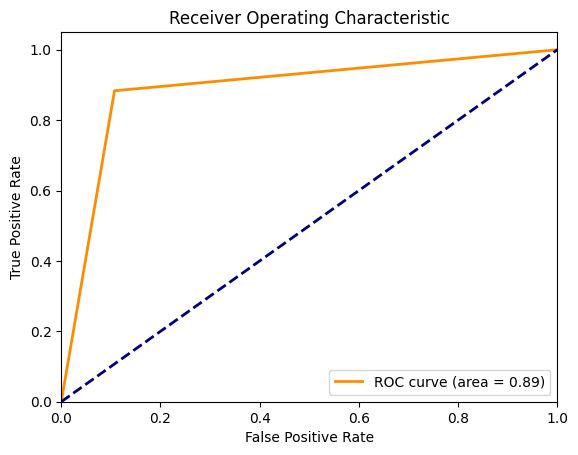

In [ ]:
fpr, tpr, thresholds = roc_curve(tokenized_datasets["test"]["label"], predicted_labels_best)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()